https://docs.opencv.org/3.4/d4/d1f/tutorial_pyramids.html

In [31]:
import numpy as np
np.set_printoptions(precision=4, threshold=10)
import dlib
import cv2 as cv
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb
%matplotlib inline

In [32]:
"""def rgb2lab_(img):
    return rgb2lab((img -np.min(img))/(np.max(img)-np.min(img))).astype(float) # normalize to [0,1]
    """

'def rgb2lab_(img):\n    return rgb2lab((img -np.min(img))/(np.max(img)-np.min(img))).astype(float) # normalize to [0,1]\n    '

In [33]:
## Loading images with integer value intensities, range(0-255)
def load_rgb(path):
    img = cv.imread(path)
    img = img[..., ::-1]
    return  img

def load_lab(path):
    img = cv.imread(path)
    img = cv.cvtColor(img, cv.COLOR_BGR2LAB)
    return img

def load_gray(path):
    img = cv.imread(path, 0) 
    return img

In [34]:
def plot_rgb(img, figsize=None, title=None, xlabel=None, ylabel=None, interpolation=None, save=False):
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    
    if interpolation != None:
        plt.imshow(img, interpolation = interpolation)
    else:
        plt.imshow(img)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if save:        
        # plt.savefig(f'../imgs/{title}.png', dpi=100, bbox_inches=0) # shit method
        plt.imsave(f'../data/outs/{title}.png', img, cmap='gray')
        
    plt.show()
    plt.close(fig)

def plot_grayscale(img, figsize=None, title=None, xlabel=None, ylabel=None, save=False):
    fig = plt.figure(num=None, figsize=figsize, dpi=100)
    
    plt.imshow(img, cmap='gray')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    if save:        
        # plt.savefig(f'../imgs/{title}.png', dpi=100, bbox_inches=0) # shit method
        plt.imsave(f'../data/outs/{title}.png', img, cmap='gray')
        
    plt.show()
    plt.close(fig)


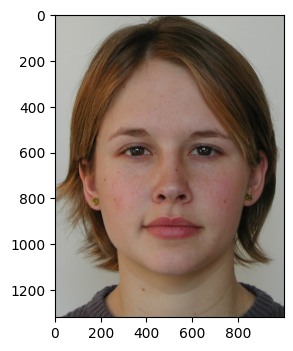

In [35]:
## Load Image

input_rgb = load_rgb('../data/inputs/input_1.png')
input_gray = load_gray('../data/inputs/input_1.png')
input_lab = load_lab('../data/inputs/input_1.png')

plot_rgb(input_rgb)
# plot_grayscale(input_gray)

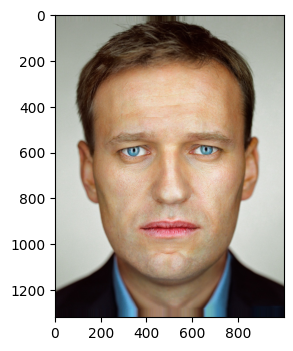

In [36]:
example_rgb = load_rgb('../data/inputs/example_1.png')
example_gray = load_gray('../data/inputs/example_1.png')
example_lab = load_lab('../data/inputs/example_1.png')

plot_rgb(example_rgb)

In [37]:
def sift_flow(img):
    img = np.copy(img)
    
    sift = cv.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    
    img_key = cv.drawKeypoints(img, kp, img)
    return img_key, kp

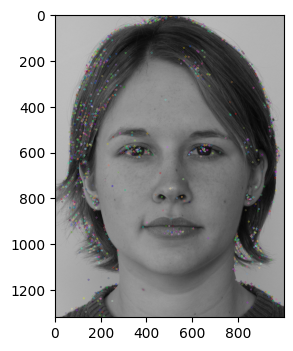

In [38]:
input_key, input_kp = sift_flow(input_gray)
# cv.imwrite('./src/sift_keypoints.png', img_key)

plot_rgb(input_key)

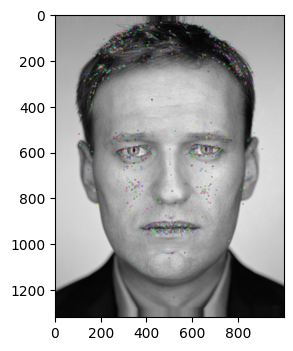

In [39]:
example_key, example_kp = sift_flow(example_gray)
plot_rgb(example_key)

In [40]:
def face_landmarks(img):
    img = np.copy(img)
    
    face_detector = dlib.get_frontal_face_detector()
    landmark_detector = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    
    # Asks the detector to fing the bounding boxes of each face
    # The 1 in the second argument indicates that we should upsample the image 1 time
    # This will make everything bigger and allow us to detect more faces
    
    total_faces = face_detector(img, 1)
    
    total_landmarks = []
    
    for k, face in enumerate(total_faces):
        landmarks = landmark_detector(img, face)
        
        for i in range(0, 68):
            x = landmarks.part(i).x
            y = landmarks.part(i).y

            total_landmarks.append([x, y])
            cv.circle(img, (x, y), 4, (255, 0, 0), -1)
            
    total_landmarks = np.array(total_landmarks)
    return img, total_landmarks

In [41]:
input_key, input_landmarks = face_landmarks(input_gray)

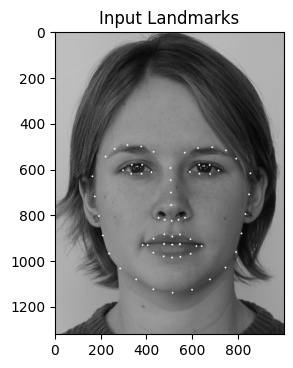

In [42]:
plot_grayscale(input_key, title='Input Landmarks')

In [43]:
example_key, example_landmarks = face_landmarks(example_gray)

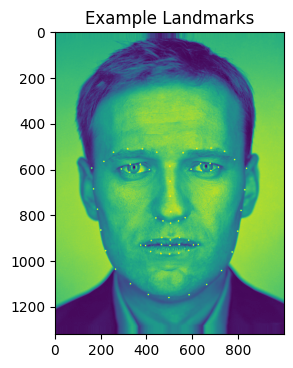

In [44]:
plot_rgb(example_key, title='Example Landmarks')

In [45]:
from scipy.spatial import Delaunay

In [46]:
def triangulation(img, img_landmarks):
    img = np.copy(img)
    
    tri = Delaunay(img_landmarks)
    triangles = img_landmarks[tri.simplices]
    
    for t in triangles:
        cv.line(img, t[0], t[1], (255, 255, 0), 2)
        cv.line(img, t[1], t[2], (255, 255, 0), 2)
        cv.line(img, t[2], t[0], (255, 255, 0), 2)
        
    return img, triangles

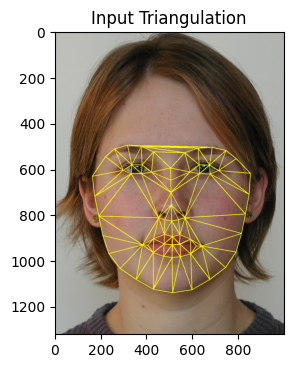

In [47]:
input_tri, input_triangles = triangulation(input_rgb, input_landmarks)
plot_rgb(input_tri, title='Input Triangulation')

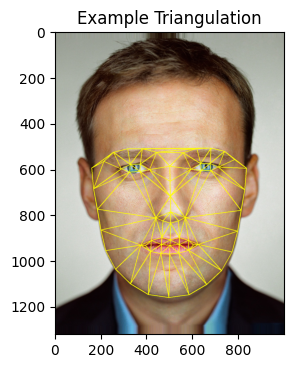

In [48]:
example_tri, example_triangles = triangulation(example_rgb, example_landmarks)
plot_rgb(example_tri, title='Example Triangulation')

In [49]:
# Check if a point is inside a rectangle
def rectContains(rect, point) :
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True

In [50]:
#calculate delanauy triangle
def calculateDelaunayTriangles(rect, points):
    #create subdiv
    subdiv = cv.Subdiv2D(rect);
    
    # Insert points into subdiv
    for p in points:
        # subdiv.insert(p)
        p = np.round(p)
        subdiv.insert([int(p[0]), int(p[1])])
    
    triangleList = subdiv.getTriangleList();
    
    delaunayTri = []
    
    pt = []    
        
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            #Get face-points (from 68 face detector) by coordinates
            for j in range(0, 3):
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)    
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph 
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        
        pt = []
        
    return delaunayTri

In [51]:
# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    src = np.copy(src)
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
    
    # Apply the Affine Transform just found to the src image
    dst = cv.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv.INTER_LINEAR, borderMode=cv.BORDER_REFLECT_101 )

    # return dst, warpMat
    return dst

In [52]:
# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :
    
    img1 = np.copy(img1)
    img2 = np.copy(img2)

    # Find bounding rectangle for each triangle
    r1 = cv.boundingRect(np.float32([t1]))
    r2 = cv.boundingRect(np.float32([t2]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))


    # Get mask by filling triangle
    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32)
    cv.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    #img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    
    size = (r2[2], r2[3])

    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    
    img2Rect = img2Rect * mask

    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
     
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 
    
    return img2

In [53]:
def warpImage(img1, img2, points1, points2):
    img1 = np.copy(img1)
    img2 = np.copy(img2)
    
    img1Warped = np.copy(img2)
    
    # Find convex hull
    hull1 = []
    hull2 = []

    hullIndex = cv.convexHull(np.array(points2), returnPoints = False)
          
    for i in range(0, len(hullIndex)):
        hull1.append(points1[int(hullIndex[i])])
        hull2.append(points2[int(hullIndex[i])])
    
    
    # Find delanauy traingulation for convex hull points
    sizeImg2 = img2.shape    
    rect = (0, 0, sizeImg2[1], sizeImg2[0])
     
    dt = calculateDelaunayTriangles(rect, hull2)
    
    if len(dt) == 0:
        quit()
    
    # Apply affine transformation to Delaunay triangles
    for i in range(0, len(dt)):
        t1 = []
        t2 = []
        
        #get points for img1, img2 corresponding to the triangles
        for j in range(0, 3):
            t1.append(hull1[dt[i][j]])
            t2.append(hull2[dt[i][j]])
        
        img1Warped = warpTriangle(img1, img1Warped, t1, t2)
    
            
    # Calculate Mask
    hull8U = []
    for i in range(0, len(hull2)):
        hull8U.append((hull2[i][0], hull2[i][1]))
    
    mask = np.zeros(img2.shape, dtype = img2.dtype)
    
    cv.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))
    
    r = cv.boundingRect(np.float32([hull2]))
    
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
        
    
    # Clone seamlessly.
    output = cv.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv.NORMAL_CLONE)
    # output = cv.seamlessClone(np.uint8(img1Warped), img1, mask, center, cv.NORMAL_CLONE)
    
    return output

In [54]:
# output = warpImage(example_rgb, input_rgb, example_landmarks, input_landmarks)
output = warpImage(input_rgb, example_rgb, input_landmarks, example_landmarks)

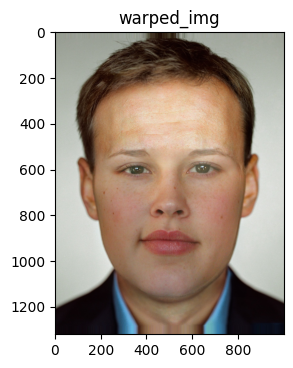

In [55]:
plot_rgb(output, title='warped_img', save=True)

In [56]:
"""
# Load the image
img = cv2.imread('../data/inputs/data/flickr2/fgs/9435356177_0037caecca_o.png')
lower = img.copy()

# Create a Gaussian Pyramid
gaussian_pyr = [lower]
for i in range(6):
    lower = cv2.pyrDown(lower)
    gaussian_pyr.append(lower)

# Last level of Gaussian remains same in Laplacian
laplacian_top = gaussian_pyr[-1]

# Create a Laplacian Pyramid
laplacian_pyr = [laplacian_top]
for i in range(6,0,-1):
    size = (gaussian_pyr[i - 1].shape[1], gaussian_pyr[i - 1].shape[0])
    print(size)
    gaussian_expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=size)
    laplacian = cv2.subtract(gaussian_pyr[i-1], gaussian_expanded)
    laplacian_pyr.append(laplacian)
    plt.figure(figsize=(10,10))
    plt.imshow(laplacian)
    plt.show()

# Reconstruct the image
reconstructed = laplacian_top
for i in range(1,7):
    size = (laplacian_pyr[i].shape[1], laplacian_pyr[i].shape[0])
    reconstructed = cv2.pyrUp(reconstructed, dstsize=size)
    reconstructed = cv2.add(reconstructed, laplacian_pyr[i])
plt.figure(figsize=(10,10))
plt.imshow(reconstructed)
plt.show()"""


"\n# Load the image\nimg = cv2.imread('../data/inputs/data/flickr2/fgs/9435356177_0037caecca_o.png')\nlower = img.copy()\n\n# Create a Gaussian Pyramid\ngaussian_pyr = [lower]\nfor i in range(6):\n    lower = cv2.pyrDown(lower)\n    gaussian_pyr.append(lower)\n\n# Last level of Gaussian remains same in Laplacian\nlaplacian_top = gaussian_pyr[-1]\n\n# Create a Laplacian Pyramid\nlaplacian_pyr = [laplacian_top]\nfor i in range(6,0,-1):\n    size = (gaussian_pyr[i - 1].shape[1], gaussian_pyr[i - 1].shape[0])\n    print(size)\n    gaussian_expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=size)\n    laplacian = cv2.subtract(gaussian_pyr[i-1], gaussian_expanded)\n    laplacian_pyr.append(laplacian)\n    plt.figure(figsize=(10,10))\n    plt.imshow(laplacian)\n    plt.show()\n\n# Reconstruct the image\nreconstructed = laplacian_top\nfor i in range(1,7):\n    size = (laplacian_pyr[i].shape[1], laplacian_pyr[i].shape[0])\n    reconstructed = cv2.pyrUp(reconstructed, dstsize=size)\n    reconstructed

In [57]:
from scipy.ndimage import gaussian_filter
img = output
def rescale(img):
    return (img - img.min()) / (img.max() - img.min())
    
def laplacian_stacks(img,xx):
    img1 = img.copy()
    laplacian_stack = [rescale(img)]
    residuals =[]
    for i in range(1,7):
        laplacian_stack.append(cv.GaussianBlur(img1, (5*(2**i)+1,5*(2**i)+1), 2**i))
        residuals.append(cv.GaussianBlur(img1, (5*(2**i)+1,5*(2**i)+1), 2**i))
        '''plt.figure(figsize=(5,5))
        plt.imshow(residuals[i-1])
        plt.show()'''

    for i in range(6):
        laplacian_stack[i] = rescale(cv.subtract( laplacian_stack[i+1],laplacian_stack[i]))
        plt.figure(figsize=(5,5))
        
        #print(laplacian_stack[i], laplacian_stack[i].shape)
        
        if xx ==1:
            #print(laplacian_stack[i])
            
            # plt.imshow(laplacian_stack[i],cmap='gray')
            # print(laplacian_stack[i].mean())
            # plt.show()
        else:
            #print(laplacian_stack[i])
            # plt.imshow(lab2rgb(laplacian_stack[i]))
            # plt.show()
    return laplacian_stack

    
def reconstructed_laplacian(laplacian_stack):
    reconstructed = laplacian_stack[0]
    
    for i in range(1,7):
        size = (laplacian_stack[i].shape[1], laplacian_stack[i].shape[0])
        #reconstructed = cv2.pyrUp(reconstructed, dstsize=size)
        reconstructed = cv.add(reconstructed, laplacian_stack[i])
        
    # plt.figure(figsize=(5,5))
    # plt.imshow(lab2rgb(reconstructed))
    # plt.show()
    
    return reconstructed
    

In [58]:
#local enery 
def local_energy(laplacian_stack,xx=0):
    s=[]
    
    for i in range(len(laplacian_stack)):
        s.append(rescale(cv.GaussianBlur(laplacian_stack[i]**2, (5*(2**(i+1))+1,5*(2**(i+1)+1)), 2**(i+1))))
        plt.figure(figsize=(5,5))
        #print(s[i])
        if xx ==1:
            plt.imshow(s[i])
            plt.show()
        else:
            plt.imshow(lab2rgb(s[i]))
            plt.show()

    return s

    


0.6889572244242197


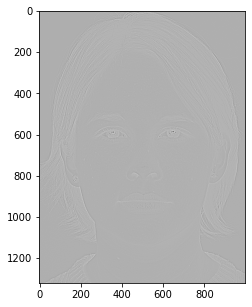

0.71647432764363


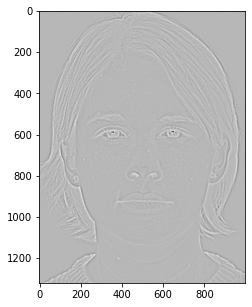

0.5672500615370786


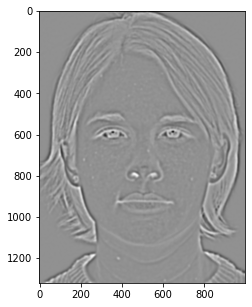

0.46884177074109057


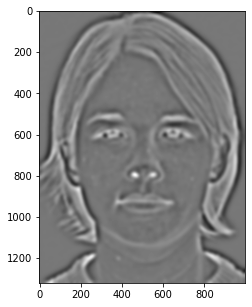

0.4939986899224981


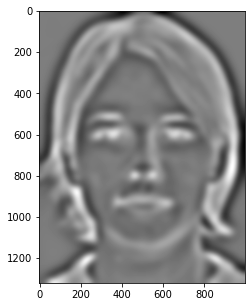

0.5705349656597288


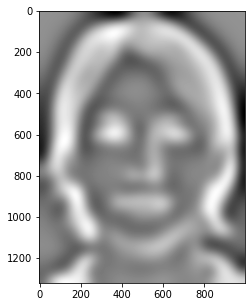

0.5066156653263819


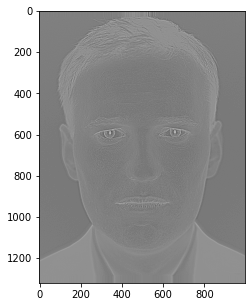

0.464901104919342


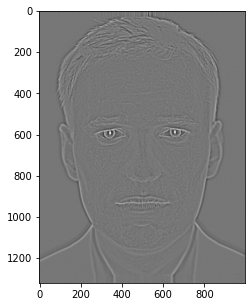

0.3638817283051611


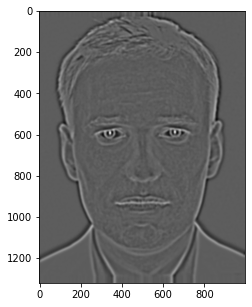

0.485061416414542


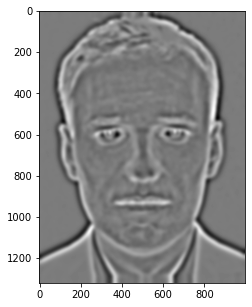

0.44686925190501436


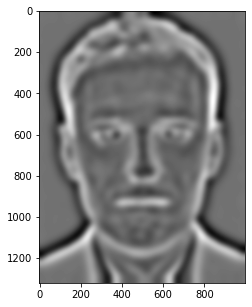

0.5167097172777626


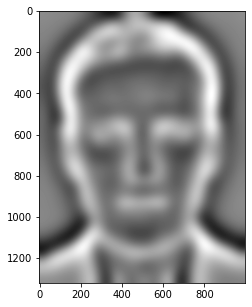

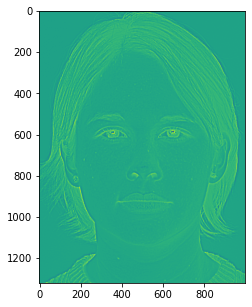

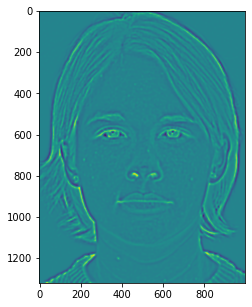

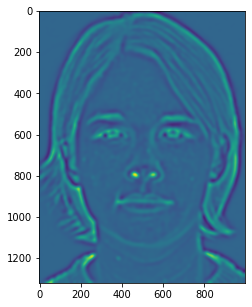

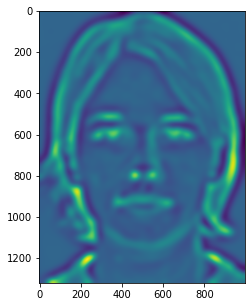

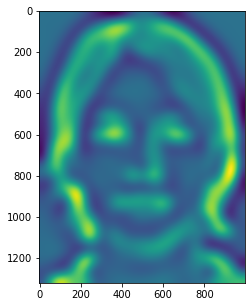

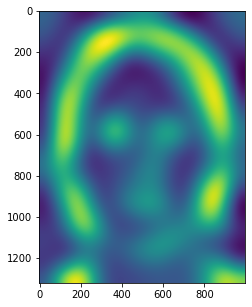

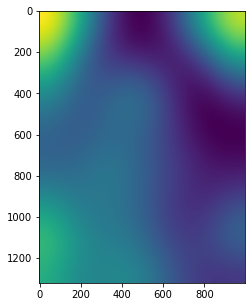

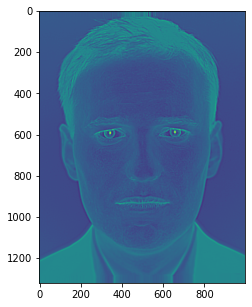

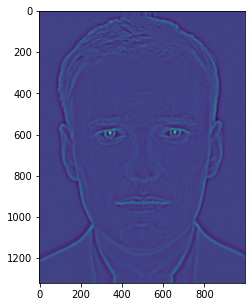

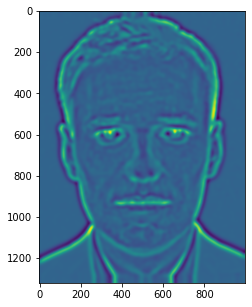

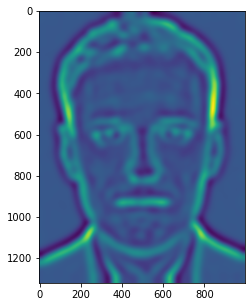

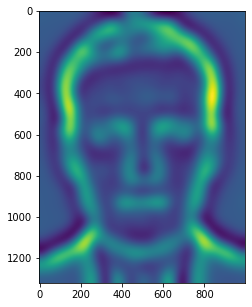

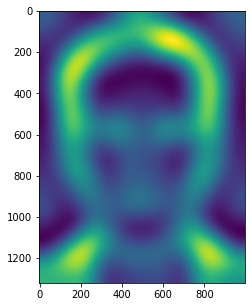

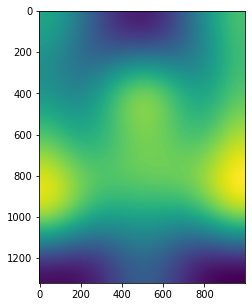

0.5932711851108893


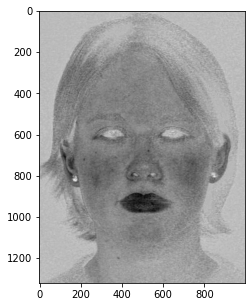

0.388248048358943


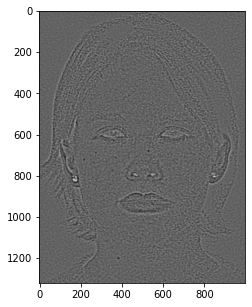

0.35792781337535184


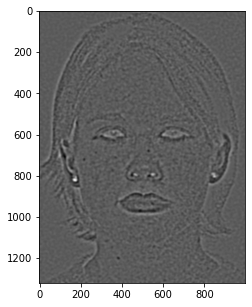

0.42761347571460523


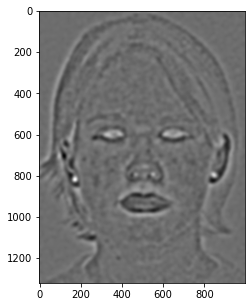

0.5026380322573873


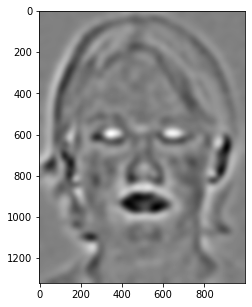

0.6557211240926882


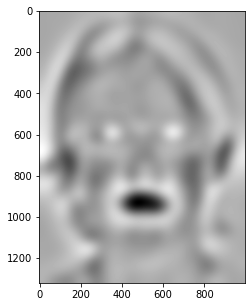

0.6706416788305065


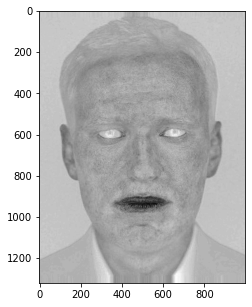

0.4240683284414581


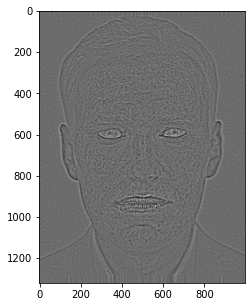

0.5271564753598998


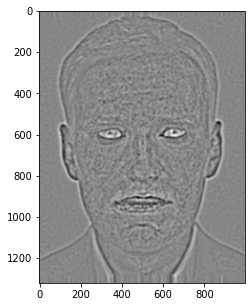

0.4976320287931593


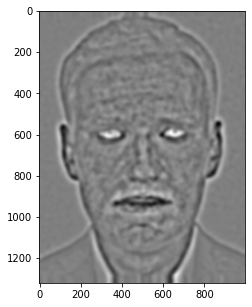

0.5693459771347039


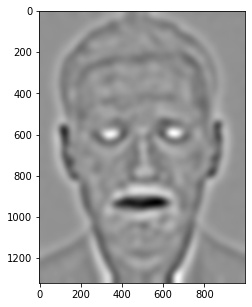

0.5996344805888119


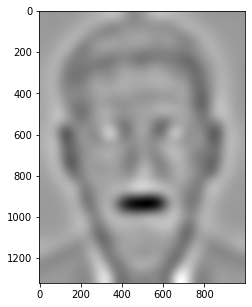

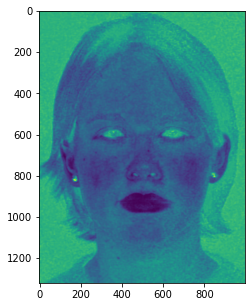

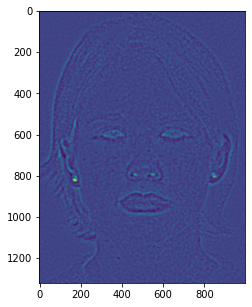

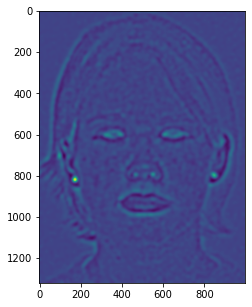

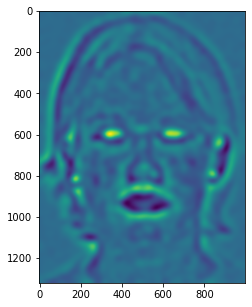

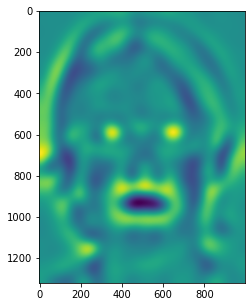

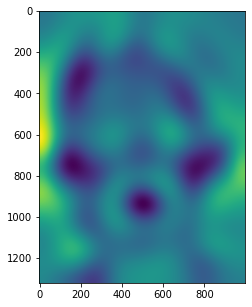

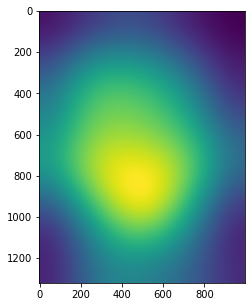

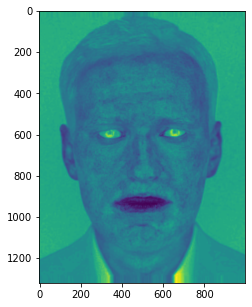

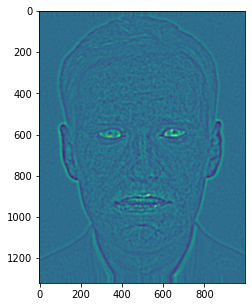

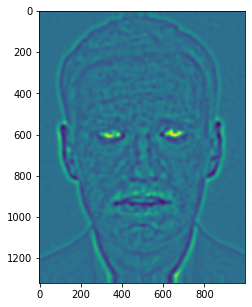

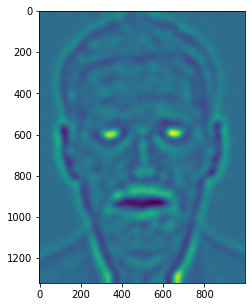

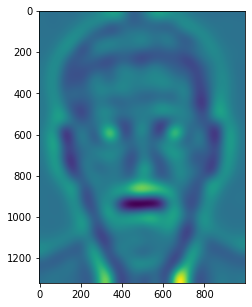

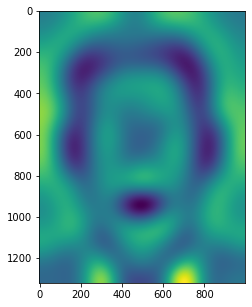

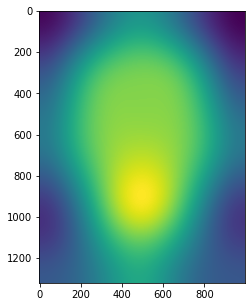

0.5175370129829209


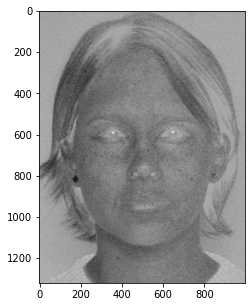

0.36486333144678385


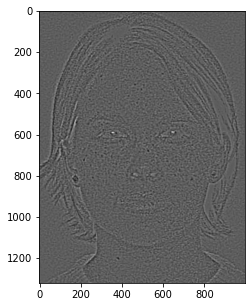

0.45356058464271976


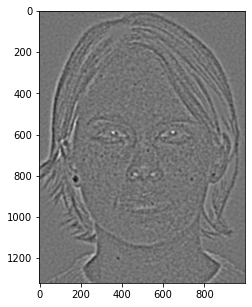

0.616078519657239


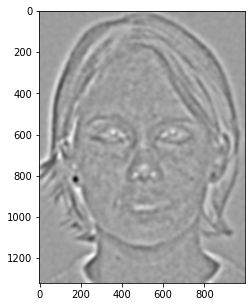

0.5256425371666767


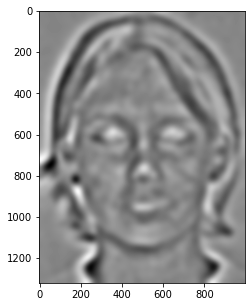

0.454922553969537


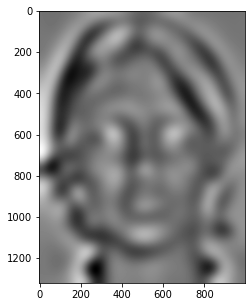

0.4427508997043206


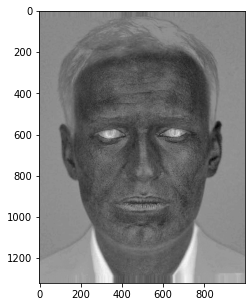

0.49269883341555454


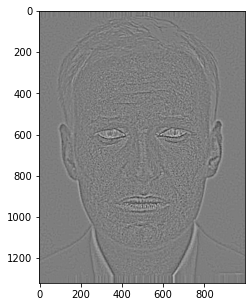

0.49920884895564366


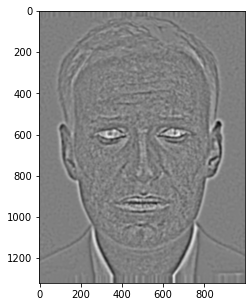

0.5276553781783102


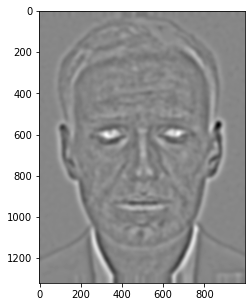

0.3929552984145449


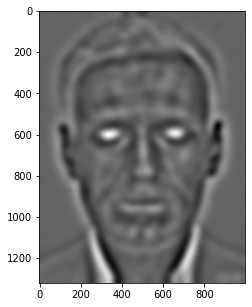

0.34141436255510277


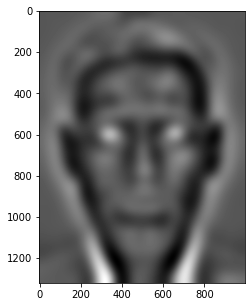

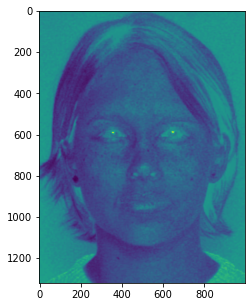

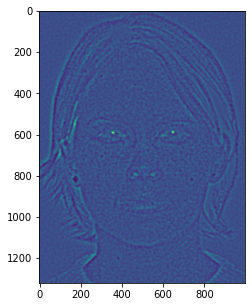

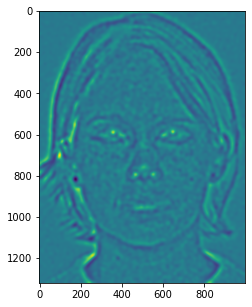

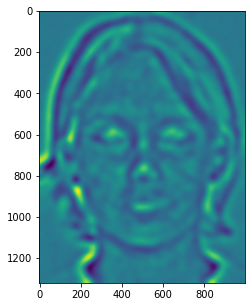

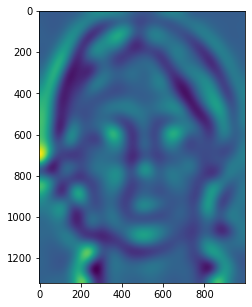

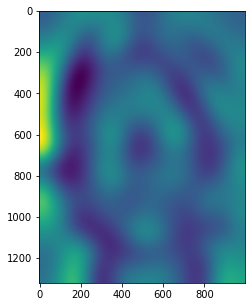

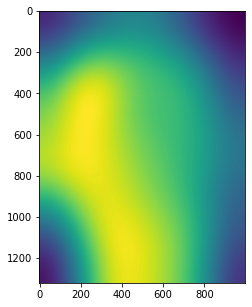

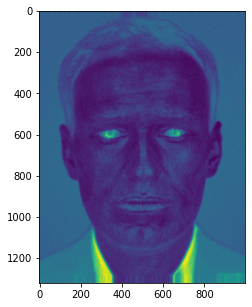

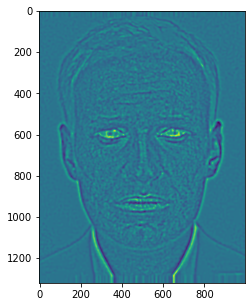

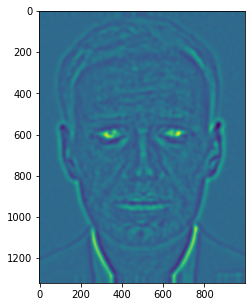

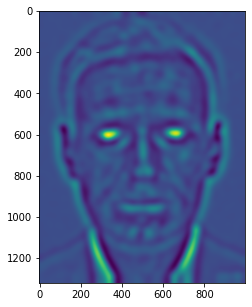

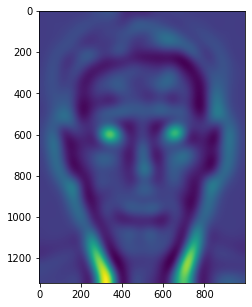

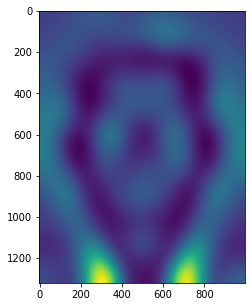

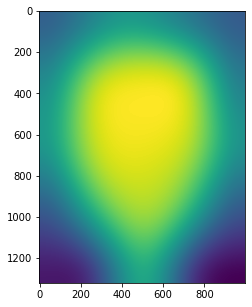

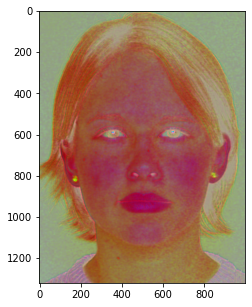

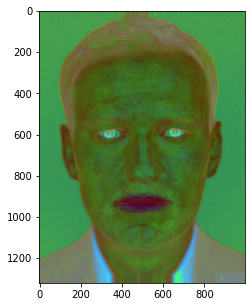

'for i in range(len(suband_input)):\n    out = warpImage(lab2rgb(suband_input[i]), lab2rgb(suband_Eample[i]), input_landmarks, example_landmarks)\n    suband_Example_star.append(out)\n    plt.figure(figsize=(5,5))\n    plt.imshow(lab2rgb(out))\n    plt.show()\n'

In [59]:
channels_input = cv.split(input_lab)
channels_Example = cv.split(example_lab)
suband_input=[]
suband_Example=[]
laplacian_stack_input = []
laplacian_stack_Example = []
for ch in range(3):
    laplacian_stack = laplacian_stacks(channels_input[ch]/255.0,1)
    laplacian_stack_e = laplacian_stacks(channels_Example[ch]/255.0,1)
    laplacian_stack_input.append(laplacian_stack)
    laplacian_stack_Example.append(laplacian_stack_e)
    suband_input.append(local_energy(laplacian_stack,1))
    suband_Example.append(local_energy(laplacian_stack_e,1))
    
#try for level 0  
s_input = np.zeros((input_lab.shape[0],input_lab.shape[1],3))
s_Example = np.zeros((input_lab.shape[0],input_lab.shape[1],3))
for ch in range(3):
    s_input[:,:,ch] = suband_input[ch][0]
    s_Example[:,:,ch] = suband_Example[ch][0]

#s_input = cv.cvtColor(s_input,cv.COLOR_LAB2RGB)
#s_Example = cv.cvtColor(s_Example,cv.COLOR_LAB2RGB)
plt.figure(figsize=(5,5))
plt.imshow(s_input)
plt.show()
plt.figure(figsize=(5,5))
plt.imshow(s_Example)
plt.show()



suband_Example_star =[]
"""for i in range(len(suband_input)):
    out = warpImage(lab2rgb(suband_input[i]), lab2rgb(suband_Eample[i]), input_landmarks, example_landmarks)
    suband_Example_star.append(out)
    plt.figure(figsize=(5,5))
    plt.imshow(lab2rgb(out))
    plt.show()
"""


In [60]:
import math
output = []
for i in range(len(suband_Example_star)):
    out = suband_Example_star[i]*np.sqrt(suband_Example_star[i]/(suband_input[i]+0.0001))
    #out = 255*((out - np.min(out))/ (np.max(out) - np.min(out)))
    #out = np.uint8(out)
    output.append(lab2rgb(out))
    plt.figure(figsize=(10,10))
    plt.imshow(out)
    plt.show()